In [23]:
#tabular data imports :
import pandas as pd
import numpy as np
import env
from env import user, password, host

# visualization imports:
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.preprocessing
from sklearn.model_selection import train_test_split

from scipy.stats import pearsonr, spearmanr
from scipy.stats import shapiro

import warnings
warnings.filterwarnings("ignore")
import wrangle as w
import os
directory = os.getcwd()

# Exercises

## Our Zillow scenario continues:

### As a Codeup data science graduate, you want to show off your skills to the Zillow data science team in hopes of getting an interview for a position you saw pop up on LinkedIn. You thought it might look impressive to build an end-to-end project in which you use some of their Kaggle data to predict property values using some of their available features; who knows, you might even do some feature engineering to blow them away. Your goal is to predict the values of single unit properties using the observations from 2017.

### In these exercises, you will run through the stages of exploration as you continue to work toward the above goal. Use only your train dataset to explore the relationships between independent variables with other independent variables or independent variables with your target variable.

In [26]:
df = w.prep_zillow(w.get_zillow_data())
df.head()

,id,bedrooms,bathrooms,sqft,taxvalue,yearbuilt,taxamount,county
4,20,4,2.0,3633,296425,2005,6941.39,LA
6,31,3,4.0,1620,847770,2011,10244.94,LA
7,33,3,2.0,2077,646760,1926,7924.68,LA
11,62,0,0.0,1200,5328,1972,91.60,LA
14,97,0,0.0,171,6920,1973,255.17,LA


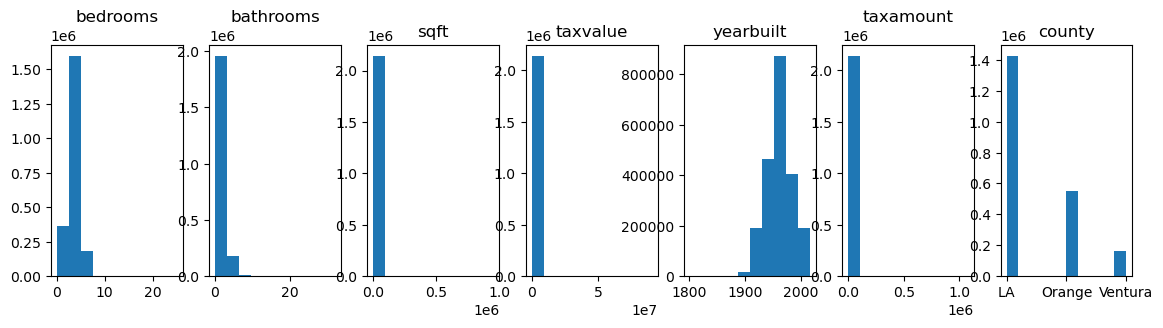

In [40]:
plt.figure(figsize=(16, 3))

# List of columns
cols = ['bedrooms','bathrooms','sqft','taxvalue','yearbuilt','taxamount','county']

for i, col in enumerate(cols):
    
    # i starts at 0, but plot no.s should start at 1
    plot_number = i + 1 
    
    # Create subplot.
    plt.subplot(1,8, plot_number)
    
    # Title with column name.
    plt.title(col)
    
    # Display histogram for column.
    df[col].hist(bins=10)
    
    # Hide gridlines.
    plt.grid(False)

In [33]:
# split the data

train, validate_and_test = train_test_split(df, train_size=.60, random_state=123)
validate, test = train_test_split(validate_and_test, test_size=.50, random_state=123)

train.shape, test.shape, validate.shape

((1284141, 8), (428047, 8), (428047, 8))

In [34]:
# 1. create the object
scaler = sklearn.preprocessing.MinMaxScaler()

# 2. fit the object (learn the min and max value)
scaler.fit(train[['bedrooms','bathrooms','yearbuilt','sqft', 'taxamount']])

MinMaxScaler()

In [35]:
train_scaled = scaler.transform(train[['bedrooms','bathrooms','yearbuilt','sqft', 'taxamount']])

In [36]:
# assign the scaled values as new columns in the train

train[['bedrooms_scaled','bathrooms_scaled','yearbuilt_scaled','sqft_scaled', 'taxamount_scaled']] = train_scaled

In [37]:
# make new scaled columns for validate and test (transform only)

validate[['bedrooms_scaled','bathrooms_scaled','yearbuilt_scaled','sqft_scaled', 'taxamount_scaled']] = scaler.transform(validate[['bedrooms','bathrooms','yearbuilt','sqft','taxamount']])
test[['bedrooms_scaled','bathrooms_scaled','yearbuilt_scaled','sqft_scaled', 'taxamount_scaled']] = scaler.transform(test[['bedrooms','bathrooms','yearbuilt','sqft','taxamount']])

In [38]:
train=train.set_index('id')

In [39]:
train.head()

,bedrooms,bathrooms,sqft,taxvalue,yearbuilt,taxamount,county,bedrooms_scaled,bathrooms_scaled,yearbuilt_scaled,sqft_scaled,taxamount_scaled
id,,,,,,,,,,,,
640628,5,4.0,3011,710674,2005,7561.14,Ventura,0.277778,0.125000,0.948837,0.005667,0.007001
5509,3,2.0,1682,603333,1961,7086.19,LA,0.166667,0.062500,0.744186,0.003165,0.006561
1374308,4,2.0,1433,82804,1954,1134.83,LA,0.222222,0.062500,0.711628,0.002696,0.001040
431433,3,2.5,2001,355444,1999,4174.92,Ventura,0.166667,0.078125,0.920930,0.003766,0.003860
1091294,4,2.0,2277,571000,1962,7113.02,LA,0.222222,0.062500,0.748837,0.004285,0.006585


## Hypotheses:

### Q1. Is there a relationship between taxamount and taxvalue?

#### both of my variables are continuous

#### **check for correlation**

#### $H_0$: There is no linear correlation between taxamount and taxvalue

#### $H_a$: There is a linear correlation between taxamount and taxvalue

In [44]:
# We already determined that all of the columns were NOT normally distributed.

# create the correlation matrix using pandas .corr()
tax_corr = train.drop(columns=['bedrooms','bathrooms','yearbuilt','sqft', 'taxamount']).corr(method='spearman')
tax_corr

,taxvalue,bedrooms_scaled,bathrooms_scaled,yearbuilt_scaled,sqft_scaled,taxamount_scaled
taxvalue,1.000000,0.295250,0.481949,0.289844,0.523634,0.978536
bedrooms_scaled,0.295250,1.000000,0.634233,0.425741,0.655474,0.296697
bathrooms_scaled,0.481949,0.634233,1.000000,0.569716,0.826175,0.481522
yearbuilt_scaled,0.289844,0.425741,0.569716,1.000000,0.511892,0.288215
sqft_scaled,0.523634,0.655474,0.826175,0.511892,1.000000,0.521115
taxamount_scaled,0.978536,0.296697,0.481522,0.288215,0.521115,1.000000


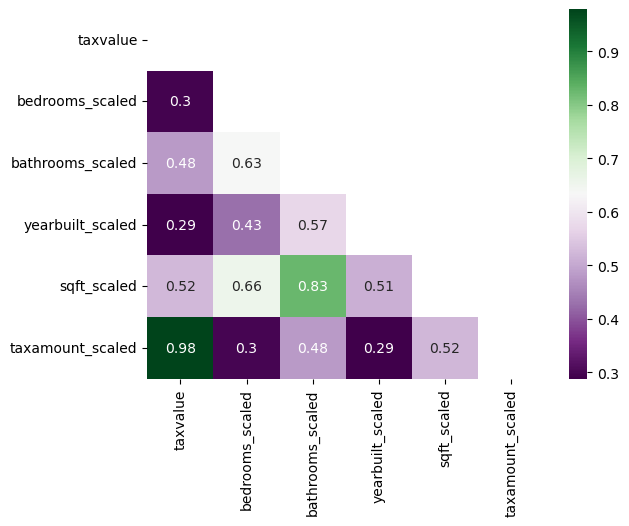

In [45]:
# pass my correlation matrix to Seaborn's heatmap with customization
sns.heatmap(tax_corr, cmap='PRGn', annot=True, 
            mask=np.triu(tax_corr))
plt.show()

In [73]:
# Since my variables are not normally distributed, 
# use scipy stats function spearmanr to calculate correlation and p-value 
α=0.05
r, p = spearmanr(train.taxamount_scaled, train.taxvalue)
if p < α:
        print(f"""We reject H₀, there is a monotonic relationship.
            Spearman’s r: {r:2f}
            P-value: {p}""")
else:
        print(f"""We fail to reject H₀: that there is a monotonic relationship.
                    Spearman’s r: {r:2f}
                    P-value: {p}""")

We reject H₀, there is a monotonic relationship.
            Spearman’s r: 0.978536
            P-value: 0.0


#### 1. Write a function named `plot_variable_pairs` that accepts a dataframe as input and plots all of the pairwise relationships along with the regression line for each pair.

#### 2. Write a function named `plot_categorical_and_continuous_vars` that accepts your dataframe and the name of the columns that hold the continuous and categorical features and outputs 3 different plots for visualizing a categorical variable and a continuous variable.

#### 3. Save the functions you have written to create visualizations in your `explore.py` file. Rewrite your notebook code so that you are using the functions imported from this file.

#### 4. Use the functions you created above to explore your Zillow train dataset in your `explore.ipynb` notebook.

#### 5. Come up with some initial hypotheses based on your goal of predicting property value.

#### 6. Visualize all combinations of variables in some way.

#### 7. Run the appropriate statistical tests where needed.

#### 8. What independent variables are correlated with the dependent variable, home value?

#### 9. Which independent variables are correlated with other independent variables (bedrooms, bathrooms, year built, square feet)?

#### 10. Make sure to document your takeaways from visualizations and statistical tests as well as the decisions you make throughout your process.

#### 11. Explore your dataset with any other visualizations you think will be helpful.

### Bonus Exercise
#### 1. In a separate notebook called `explore_mall`, use the functions you have developed in this exercise with the `mall_customers` dataset in the Codeup database server. You will need to write a sql query to acquire your data. Make `spending_score` your target variable.